# 微分方程式の逆問題
- ダイナミクスパラメータをデータから同定する
## 鉛直投げ上げ

In [1]:
import jax
import jax.numpy as jnp
import jax.experimental.ode as ode

import numpyro
import numpyro.distributions as dist
import arviz as az

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(3)

## 状態方程式の定式化
状態量$z$は鉛直位置と速度（上方向が正）
$$
z = [p~~v]^T
$$
$ma = F$より
$$
\dot{v} = -g-\frac{\gamma}{m}v
$$
ただし、$\gamma$は空気抵抗係数, $g$は重力加速度,　$m$は投げ上げる物体の質量　<br>
よって、
$$
\dot{z} = \begin{bmatrix}
0 & 1 \\
0 & -\frac{\gamma}{m}
\end{bmatrix}z+
\begin{bmatrix}
0 \\
-1
\end{bmatrix}g
$$

この$\gamma$をデータから推定する

In [3]:
def dz_dt(z, t, m, g, gamma):
    A = jnp.array([[0, 1],[0, -gamma/m]])
    B = jnp.array([0,-1])
    d_z = jnp.dot(A, z) + B.T*g
    return d_z.T

In [4]:
m = 2.
g = 9.8
r = 0.4

t_true = jnp.arange(0, 10, 0.5).astype(float)
z_init = jnp.array([0, 50]).astype(float)

#odeの引数は、（状態方程式の関数、状態量の初期値、時間、状態方程式の関数の引数たち*)
z = ode.odeint(dz_dt, z_init, t_true, m, g, r)

p_true = z[:, 0]
v_true = z[:, 1]

In [5]:
np.random.seed(123)

sigma = 5.0
n_observed = 12

t_observed = t_true[:n_observed]
p_observed = np.random.normal(p_true[:n_observed], sigma)

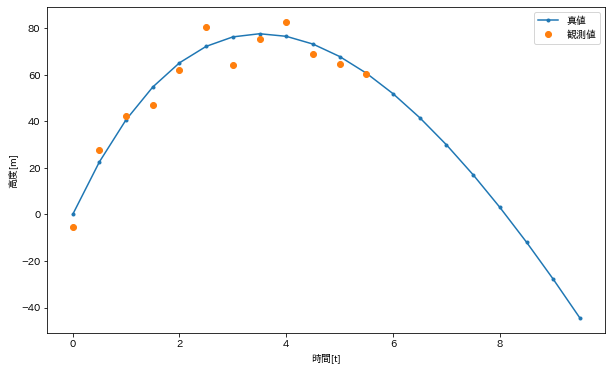

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(t_true, p_true, ".-", label="真値")
plt.plot(t_observed, p_observed, "o", label="観測値")

plt.xlabel("時間[t]")
plt.ylabel("高度[m]")
plt.legend();

## モデリング
### 系列モデル
- 状態遷移モデル
    - $z_t \sim p(z_t|z_{t-1},\gamma)$
- 観測モデル
    - $p_t \sim \mathcal{N}(p_t|z_t, \sigma)$
- 事前分布
    - $p(\gamma)$
    - $p(z_1)$


In [25]:
def model(t, p_observed=None):
    # 状態量の初期値の事前分布
    p_init = numpyro.sample("p_init", dist.Normal(0, 10))
    v_init = numpyro.sample("v_init", dist.Normal(50, 10))
    
    z_init = jnp.stack([p_init, v_init])
    
    # 空気抵抗係数の事前分布
    gamma = numpyro.sample("gamma", dist.LogNormal(0, 1))
    # ode使った状態遷移
    z = ode.odeint(dz_dt, z_init, t, m, g, gamma)
    
    # 観測モデルの分散の事前分布
    sigma = numpyro.sample("sigma", dist.HalfNormal(10))
    # 観測モデル（尤度）
    numpyro.sample("obs", dist.Normal(z[:, 0], sigma), obs=p_observed)

In [17]:
nuts = numpyro.infer.NUTS(model)

In [18]:
mcmc = numpyro.infer.MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=3)
mcmc.run(jax.random.PRNGKey(0), t_observed, p_observed=p_observed)
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

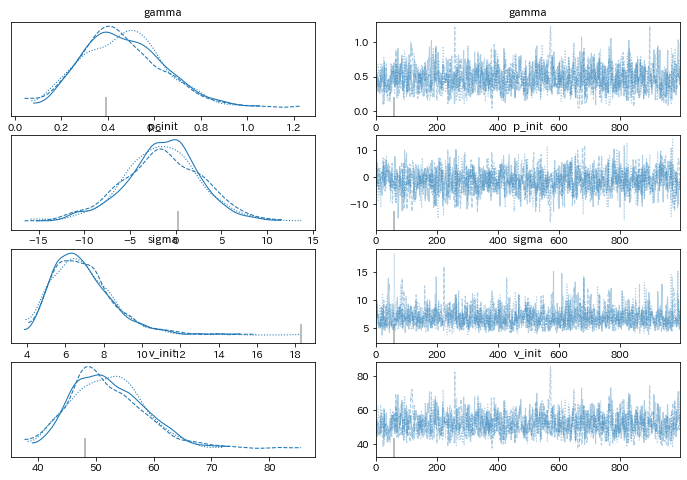

In [19]:
az.plot_trace(idata);

In [20]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.466,0.177,0.140,0.782,0.005,0.004,1052.0,1053.0,1.0
p_init,-1.459,4.228,-9.481,6.972,0.131,0.093,1032.0,1401.0,1.0
sigma,6.936,1.632,4.262,9.809,0.044,0.031,1311.0,1566.0,1.0
v_init,52.074,6.249,41.131,63.498,0.206,0.147,919.0,923.0,1.0


In [21]:
t_pred = jnp.arange(0, 10, 0.5).astype(float)

In [22]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(0), t_pred)

p_pred = ppc_samples['obs']

In [23]:
mu_pred = jnp.mean(p_pred, 0)
pi_pred = jnp.percentile(p_pred, jnp.array([5, 95]), 0)

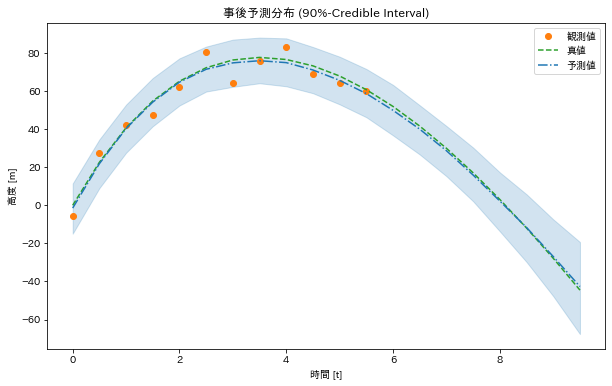

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(t_observed, p_observed, "o", color="C1", label="観測値")
plt.plot(t_true, p_true, "--", color="C2", label="真値")

plt.plot(t_pred, mu_pred, "-.", color="C0", label="予測値")
plt.fill_between(t_pred, pi_pred[0, :], pi_pred[1, :], color="C0", alpha=0.2)

plt.title('事後予測分布 (90%-Credible Interval)')
plt.xlabel('時間 [t]')
plt.ylabel('高度 [m]')

plt.legend();